In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
from forge_class_instance3 import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from lifelines.utils import concordance_index
from sklearn.metrics import r2_score
%matplotlib inline

/home/sreeramp/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
forge_model = FORGE.load_forge(path='/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Models/optuna_models/ERLOTINIB_EGFR_forgeModel_optuna100.pkl')
# forge_model.best_hyperparams

In [3]:
exp_data = pd.read_csv(forge_model.exp_path, header = 0, index_col = 0)
dep_data = pd.read_csv(forge_model.dep_path, header = 0, index_col = 0)
ic50_data = pd.read_csv(forge_model.ic50_path, header = 0, index_col = 0)
ic50_data = forge_model.ic50_data.T
exp_data.shape, dep_data.shape, ic50_data.shape

((1076, 16289), (1076, 17916), (1325, 187))

In [4]:
common_cellLines = list(set(exp_data.index) & set(dep_data.index) & set(ic50_data.index))
len(common_cellLines)

700

In [5]:
exp_data_subset = exp_data.loc[common_cellLines, forge_model.hcg_list].drop_duplicates(keep='first')
dep_target = dep_data.loc[common_cellLines, forge_model.target].dropna().drop_duplicates(keep='first')
drug_ic50 = ic50_data.loc[common_cellLines, forge_model.drug].dropna().drop_duplicates(keep='first')
exp_data_subset = exp_data.loc[dep_target.index, forge_model.hcg_list]
drug_ic50 = ic50_data.loc[dep_target.index, forge_model.drug]
exp_data_subset.shape, dep_target.shape, drug_ic50.shape

((699, 201), (699,), (699,))

In [6]:
exp_data_subset.head()

,MYBL1,UBL7-DT,AK5,REPS1,GGN,SQSTM1,NFIC,B3GNT3,SH2D3A,PERP,...,SYDE1,CRYBG2,FXYD3,RCC2-AS1,STARD8,ITGB4,HS3ST1,TMEM115,CRB3,EGFR
StrippedCellLineName,,,,,,,,,,,,,,,,,,,,,
PANC0504,-1.748249,1.243653,-7.814339,4.988783,-5.006984,10.214922,6.627633,7.351157,5.491296,9.086894,...,-2.456787,3.786968,9.347374,2.379187,2.144214,9.856034,6.780977,5.292388,3.640475,6.992865
SNU738,6.994908,1.924412,1.126306,4.682710,-0.228256,7.910294,6.879381,-3.555518,1.092607,6.031183,...,6.814483,0.867014,-2.379668,2.677569,-3.356209,7.392065,-3.555518,5.943073,-1.233590,8.220412
MOLM13,1.755228,2.874527,-1.596862,5.869595,-2.320345,7.315479,5.588362,-2.461207,1.095741,-1.207451,...,-2.461207,-2.537156,-2.702215,3.231386,4.961397,0.346148,0.796422,4.568823,-2.537156,-0.713187
JJN3,5.856692,3.103022,-4.267330,4.504668,-2.475916,9.314803,6.112465,-2.682367,4.659537,5.076796,...,-3.212882,-3.575452,-1.367857,3.197766,1.577195,0.823394,1.057370,4.748836,-2.838486,-0.042957
KIJK,4.704078,2.260866,-3.526006,6.053707,-0.012382,7.777505,5.280841,-4.314501,3.326072,7.137974,...,-2.819737,-3.526006,-1.992573,2.811968,-4.073493,2.503354,-5.452005,5.537673,-4.314501,-0.356081


In [7]:
dep_target.head()

StrippedCellLineName
PANC0504    0.859767
SNU738      0.034309
MOLM13      0.102825
JJN3        0.127770
KIJK        0.096951
Name: EGFR, dtype: float64

In [8]:
drug_ic50.head()

StrippedCellLineName
PANC0504    5.42741
SNU738      6.45318
MOLM13      2.06927
JJN3        9.45535
KIJK        3.59361
Name: ERLOTINIB, dtype: float64

In [9]:
forge_model.exp_data = exp_data_subset
forge_model.dep_data = dep_target
forge_model.ic50_data = drug_ic50
forge_model.exp_data.shape, forge_model.dep_data.shape, forge_model.ic50_data.shape

((699, 201), (699,), (699,))

In [10]:
common_train_cellLines = list(set(forge_model.train_cellLines) & set(forge_model.exp_data.index))
common_test_cellLines = list(set(forge_model.test_cellLines) & set(forge_model.exp_data.index))

In [11]:
all_cellLines = common_train_cellLines[:]
all_cellLines.extend(common_test_cellLines)
len(all_cellLines)

686

In [ ]:
G_train = forge_model.exp_data.loc[common_train_cellLines, :].to_numpy()
G_test  = forge_model.exp_data.loc[common_test_cellLines, :].to_numpy()

D_train = forge_model.dep_data.loc[common_train_cellLines].to_numpy().reshape(-1, 1)
D_test  = forge_model.dep_data.loc[common_test_cellLines].to_numpy().reshape(-1, 1)

I_train = forge_model.ic50_data.loc[common_train_cellLines].to_numpy().reshape(-1, 1)
I_test  = forge_model.ic50_data.loc[common_test_cellLines].to_numpy().reshape(-1, 1)

G_train.shape, D_train.shape, I_train.shape, G_test.shape, D_test.shape, I_test.shape

((549, 201), (549, 1), (549, 1), (137, 201), (137, 1), (137, 1))

In [13]:
## Construct weight matrices
dep_imp = forge_model.W @ forge_model.hD
ic50_imp = forge_model.W @ forge_model.hI
gene_imp_df = pd.DataFrame({'dep_imp': dep_imp.flatten(),
                            'ic50_imp': ic50_imp.flatten()},
                           index = forge_model.hcg_list)
gene_imp_df.head()

,dep_imp,ic50_imp
MYBL1,-0.000732,0.048128
UBL7-DT,-0.001444,-0.017670
AK5,0.005105,0.070035
REPS1,-0.000437,-0.068537
GGN,-0.005745,0.075533


In [14]:
gene_imp_df['combined'] = gene_imp_df['dep_imp'] - gene_imp_df['ic50_imp']
gene_imp_df['scaled_combined'] = (gene_imp_df['combined'] - np.mean(gene_imp_df['combined'])) / np.std(gene_imp_df['combined'])
gene_imp_df.head()

,dep_imp,ic50_imp,combined,scaled_combined
MYBL1,-0.000732,0.048128,-0.048860,-0.537553
UBL7-DT,-0.001444,-0.017670,0.016225,0.205589
AK5,0.005105,0.070035,-0.064930,-0.721044
REPS1,-0.000437,-0.068537,0.068100,0.797892
GGN,-0.005745,0.075533,-0.081278,-0.907704


In [15]:
gene_imp_df.to_csv('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/EGFR_ERLOTINIB_geneImp_optuna.csv', index=True)

#### Gene importance plot

In [16]:
gene_imp_df['gene'] = gene_imp_df.index
top_5 = gene_imp_df.sort_values(by='scaled_combined', ascending=False).head(5)['gene'].tolist()
bottom_5 = gene_imp_df.sort_values(by='scaled_combined', ascending=True).head(5)['gene'].tolist()
gene_imp_df['marker'] = np.where(gene_imp_df['gene'].isin(top_5), 'top_5', np.where(gene_imp_df['gene'].isin(bottom_5), 'bottom_5', 'normal'))
gene_imp_df.head()

,dep_imp,ic50_imp,combined,scaled_combined,gene,marker
MYBL1,-0.000732,0.048128,-0.048860,-0.537553,MYBL1,normal
UBL7-DT,-0.001444,-0.017670,0.016225,0.205589,UBL7-DT,normal
AK5,0.005105,0.070035,-0.064930,-0.721044,AK5,normal
REPS1,-0.000437,-0.068537,0.068100,0.797892,REPS1,normal
GGN,-0.005745,0.075533,-0.081278,-0.907704,GGN,normal


In [17]:
gene_imp_df['scaled_combined'].describe()

count    2.010000e+02
mean     8.837596e-18
std      1.002497e+00
min     -2.764409e+00
25%     -6.765257e-01
50%     -2.636136e-02
75%      7.108679e-01
max      2.790813e+00
Name: scaled_combined, dtype: float64

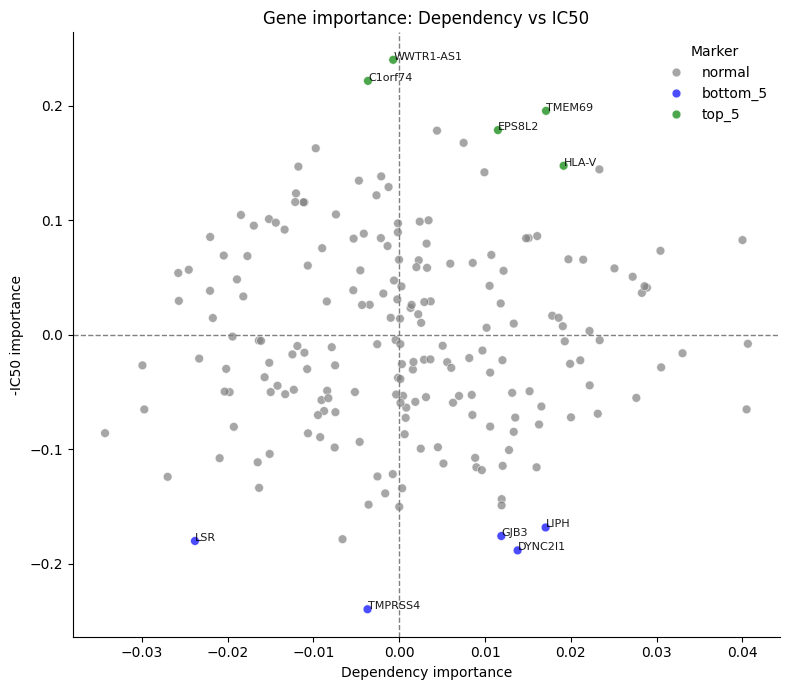

In [18]:
custom_palette = {'top_5': 'green', 'bottom_5': 'blue', 'normal': 'grey'}
# --------------------------------------------------
# Create a plotting copy and flip IC50 importance
# --------------------------------------------------
plot_df = gene_imp_df.copy()
plot_df['ic50_imp_neg'] = -1 * plot_df['ic50_imp']

# --------------------------------------------------
# Add jitter (small noise)
# --------------------------------------------------
jitter_strength = 0.01  # tune if needed
plot_df['dep_jit'] = plot_df['dep_imp'] + np.random.normal(0, jitter_strength, size=len(plot_df))
plot_df['ic50_jit'] = plot_df['ic50_imp_neg'] + np.random.normal(0, jitter_strength, size=len(plot_df))

# --------------------------------------------------
# Scatter plot
# --------------------------------------------------
plt.figure(figsize=(8, 7))

sns.scatterplot(
    x='dep_jit',
    y='ic50_jit',
    hue='marker',
    palette=custom_palette,
    data=plot_df,
    alpha=0.7,
    s=40
)

# --------------------------------------------------
# Zero reference lines
# --------------------------------------------------
plt.axhline(0, linestyle='--', color='grey', linewidth=1)
plt.axvline(0, linestyle='--', color='grey', linewidth=1)

# --------------------------------------------------
# Label only top_20 and bottom_20
# --------------------------------------------------
label_df = plot_df[plot_df['marker'].isin(['top_5', 'bottom_5'])]

for _, row in label_df.iterrows():
    plt.text(
        row['dep_jit'],
        row['ic50_jit'],
        row['gene'],          # change if your label column has a different name
        fontsize=8,
        alpha=0.9
    )

# --------------------------------------------------
# Cosmetics
# --------------------------------------------------
plt.xlabel('Dependency importance')
plt.ylabel('-IC50 importance')
plt.title('Gene importance: Dependency vs IC50')
plt.legend(title='Marker', frameon=False)
sns.despine()

plt.tight_layout()
plt.savefig('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Figs/egfr_erlotinib_geneImp_top10_optuna.pdf', dpi=300)
plt.show()


#### Benefit score computations

In [19]:
full_exp_data = forge_model.exp_data.loc[all_cellLines, gene_imp_df.index]
full_exp_data_scaled = (full_exp_data - forge_model.mean_exp) / forge_model.std_exp
D_train, D_test = D_train - forge_model.mean_dep, D_test - forge_model.mean_dep
I_train, I_test = I_train - forge_model.mean_ic50, I_test - forge_model.mean_ic50
full_exp_data_scaled.shape, gene_imp_df.shape, D_train.shape, I_train.shape

((686, 201), (201, 6), (549, 1), (549, 1))

In [20]:
Z_matrix = full_exp_data_scaled.to_numpy() @ forge_model.W
Z_matrix.shape

(686, 25)

In [21]:
z_values_df = pd.DataFrame(Z_matrix, index=all_cellLines, columns=[f'dim{i}' for i in range(Z_matrix.shape[1])])
z_values_df['scaled_dep'] = D_train.flatten().tolist() + D_test.flatten().tolist()
z_values_df['scaled_ic50'] = I_train.flatten().tolist() + I_test.flatten().tolist()
z_values_df['pred_dep'] = (z_values_df[[f'dim{i}' for i in range(Z_matrix.shape[1])]].to_numpy() @ forge_model.hD).flatten() 
z_values_df['pred_ic50'] = (z_values_df[[f'dim{i}' for i in range(Z_matrix.shape[1])]].to_numpy() @ forge_model.hI).flatten()
z_values_df.head()

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim19,dim20,dim21,dim22,dim23,dim24,scaled_dep,scaled_ic50,pred_dep,pred_ic50
SNU738,3.271961,-4.018867,-4.899347,-15.506899,2.955059,5.677474,13.292991,-19.063476,15.501051,-29.995468,...,-6.083742,6.341812,-1.477674,-2.624102,25.119702,5.722402,-0.230786,1.152115,-0.225747,0.593844
MOLM13,8.317699,41.192314,-5.915385,-36.119863,0.407003,-20.714155,-11.340161,-9.353185,6.130111,20.440144,...,40.276342,-27.223802,3.545575,2.245294,-43.325458,9.905631,-0.162269,-3.231795,-0.309096,-1.316212
JJN3,8.358061,21.522597,-10.439452,-11.719498,6.663718,-0.970149,-11.511258,-2.278850,5.424331,-13.950373,...,27.279580,-24.517122,-17.141236,-11.124977,-34.104745,8.854917,-0.137324,4.154285,-0.155550,-0.341632
KIJK,-5.054899,27.844250,10.870553,2.623360,-24.148024,11.304137,-13.297214,-10.558601,6.815701,-22.115398,...,-2.737245,-29.511627,-2.877044,15.258351,-23.229377,15.070728,-0.168143,-1.707455,-0.219839,0.464876
CAL78,3.847144,-18.287519,1.449785,17.510231,-16.894509,-4.970017,1.324392,5.075076,12.194980,-21.368151,...,-17.755439,-14.860223,12.081873,-8.208242,-1.908956,-4.278607,-0.177509,0.521515,-0.119244,1.774431


In [22]:
z_values_df['set'] = ['train' if cl in common_train_cellLines else 'test' for cl in z_values_df.index]
z_values_df['cell_line'] = z_values_df.index
z_values_df['benefit_score_raw'] = z_values_df['pred_dep'] - z_values_df['pred_ic50']
z_values_df['benefit_score_scaled'] = (z_values_df['benefit_score_raw'] - np.min(z_values_df['benefit_score_raw'])) / (np.max(z_values_df['benefit_score_raw']) - np.min(z_values_df['benefit_score_raw']))
z_values_df.head()

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim23,dim24,scaled_dep,scaled_ic50,pred_dep,pred_ic50,set,cell_line,benefit_score_raw,benefit_score_scaled
SNU738,3.271961,-4.018867,-4.899347,-15.506899,2.955059,5.677474,13.292991,-19.063476,15.501051,-29.995468,...,25.119702,5.722402,-0.230786,1.152115,-0.225747,0.593844,train,SNU738,-0.819591,0.406986
MOLM13,8.317699,41.192314,-5.915385,-36.119863,0.407003,-20.714155,-11.340161,-9.353185,6.130111,20.440144,...,-43.325458,9.905631,-0.162269,-3.231795,-0.309096,-1.316212,train,MOLM13,1.007116,0.629621
JJN3,8.358061,21.522597,-10.439452,-11.719498,6.663718,-0.970149,-11.511258,-2.278850,5.424331,-13.950373,...,-34.104745,8.854917,-0.137324,4.154285,-0.155550,-0.341632,train,JJN3,0.186082,0.529555
KIJK,-5.054899,27.844250,10.870553,2.623360,-24.148024,11.304137,-13.297214,-10.558601,6.815701,-22.115398,...,-23.229377,15.070728,-0.168143,-1.707455,-0.219839,0.464876,train,KIJK,-0.684715,0.423425
CAL78,3.847144,-18.287519,1.449785,17.510231,-16.894509,-4.970017,1.324392,5.075076,12.194980,-21.368151,...,-1.908956,-4.278607,-0.177509,0.521515,-0.119244,1.774431,train,CAL78,-1.893675,0.276080


In [23]:
z_values_df['benefit_score_scaled'].describe()

count    686.000000
mean       0.506332
std        0.166194
min        0.000000
25%        0.383565
50%        0.491221
75%        0.610724
max        1.000000
Name: benefit_score_scaled, dtype: float64

In [24]:
z_plot_df = z_values_df.drop(columns=[i for i in z_values_df.columns if not i.startswith('dim')])
z_plot_df = z_plot_df.sort_index()
z_values_df = z_values_df.loc[z_plot_df.index]
z_plot_df.head()

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24
22RV1,15.070516,2.110318,12.507632,-12.300128,12.533052,-7.315223,-3.968436,2.595230,-6.310228,12.178791,...,1.948762,0.735139,-8.655559,-7.666214,15.620449,-11.788260,-5.811699,8.377661,5.578766,-0.619777
2313287,15.126697,3.992169,-2.582105,-0.565921,15.970295,-1.398219,6.329730,18.360206,-0.696256,12.463213,...,12.032546,-4.725141,-8.709320,-22.985779,11.522511,8.739169,-11.315331,-1.653326,4.861144,-0.064647
253J,-25.841629,5.444899,-13.283011,-8.433864,4.070306,16.237590,9.521778,-15.382223,13.286316,-8.847282,...,-13.465101,-2.118349,-11.563794,-8.855336,-28.032172,19.118163,1.983315,13.735245,7.417003,11.142777
253JBV,-20.077915,4.045209,-18.874968,-7.184408,13.056097,9.383398,-2.857666,-5.584618,9.323419,-7.079888,...,-15.916146,1.974370,-3.203927,0.045072,-20.031467,27.402858,6.801945,20.246517,9.459428,5.950287
42MGBA,3.426879,-11.711808,20.527376,-6.841866,-22.475261,-4.091241,13.658918,-6.201748,21.617220,-4.023104,...,-0.584357,12.125294,-14.916517,23.043671,-15.675089,-9.347542,6.696579,12.134967,-9.231063,-4.732990


In [25]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from matplotlib import rcParams
from dynamicTreeCut import cutreeHybrid
from matplotlib.patches import Patch

Performing hierarchical clustering on the combined dataset...
..cutHeight not given, setting it to 906.7233274323804  ===>  99% of the (truncated) height range in dendro.
..done.
Dynamic Tree Cut found 30 clusters.
Generating the final heatmap...


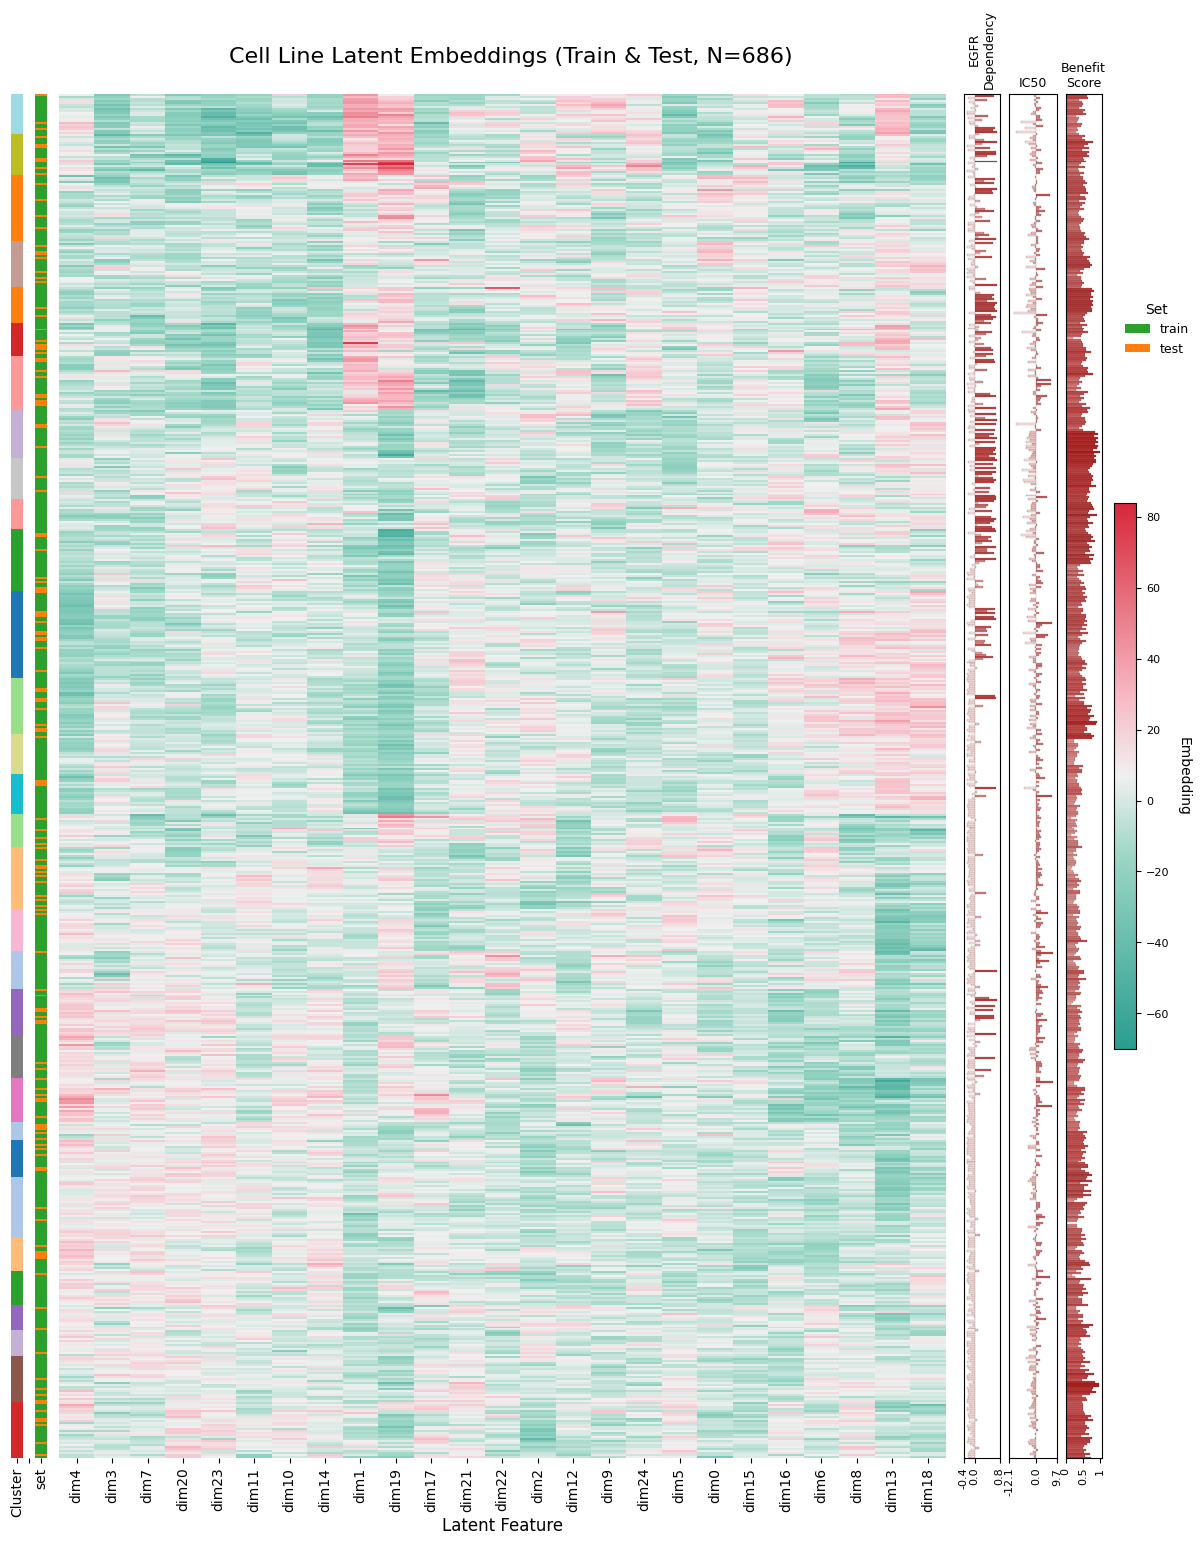

In [ ]:
# === 3. Hierarchical Clustering and Annotation Color Mapping (on Combined Data) ===

print("Performing hierarchical clustering on the combined dataset...")

# --- Step 3a: Compute linkage matrices for the combined data ---
row_dist = pdist(z_plot_df.values, metric='euclidean')
row_link = linkage(row_dist, method='ward')
col_link = linkage(pdist(z_plot_df.T.values), method='ward')

# --- Step 3b: Run Dynamic Tree Cut to find clusters ---
cluster_result = cutreeHybrid(
    row_link, row_dist, deepSplit=4, minClusterSize=13)  # Set a min size
cluster_labels = pd.Series(
    cluster_result["labels"], index=z_plot_df.index, name="Cluster")
num_clusters = len(np.unique(cluster_labels[cluster_labels != 0]))
print(f"Dynamic Tree Cut found {num_clusters} clusters.")

# --- Step 3c: Create annotation colors ---
row_colors_df = pd.DataFrame(index=z_plot_df.index)

# Annotation 1: Dynamic Tree Cut Clusters
unique_clusters = sorted(np.unique(cluster_labels))
palette = sns.color_palette("tab20", len(unique_clusters))
cluster_lut = dict(zip(unique_clusters, palette))
cluster_lut[0] = 'lightgrey'  # Unclustered points
row_colors_df["Cluster"] = cluster_labels.map(cluster_lut)

# Annotation 2: Train vs. Test Set
set_lut = {"train": "#2ca02c", "test": "#ff7f0e"}  # Green and Orange
row_colors_df["set"] = z_values_df["set"].map(set_lut)

# White bar to add space between cluster and set
row_colors_df[" "] = "#ffffff"
# Reorder to force the stacking order: Cluster (top), Spacer, then Set
row_colors_df = row_colors_df[["Cluster", " ", "set"]]


# === 4. Define Colormaps ===
deep_green = '#2a9d8f'
soft_green = '#9bd6c5'
neutral = '#f0f0f0'
soft_pink = '#f7b7c3'
deep_pink = '#d62839'
green_pink_cmap = LinearSegmentedColormap.from_list('green_pink_cmap', [(
    0.0, deep_green), (0.35, soft_green), (0.5, neutral), (0.65, soft_pink), (1.0, deep_pink)], N=256)
muted_reds = LinearSegmentedColormap.from_list(
    "muted_reds", ["mistyrose", "indianred", "firebrick"])
benefit_cmap = sns.diverging_palette(
    240, 10, as_cmap=True)  # Blue to Red for benefit score

# === 5. Generate the Final Clustered Heatmap ===
print("Generating the final heatmap...")
cg = sns.clustermap(
    z_values_df,
    row_linkage=row_link,
    col_linkage=col_link,
    row_colors=row_colors_df,  # Pass the DataFrame with both annotations
    cmap=green_pink_cmap,
    figsize=(12, 15),
    cbar_pos=None,  # We will create all colorbars manually
    dendrogram_ratio=(0.04, 0.03),
    linewidths=0
)

# Rasterize the heatmap blocks (all quadmesh artists in heatmap)
for artist in cg.ax_heatmap.collections:
    artist.set_rasterized(True)

# === 6. Fine-tune Layout and Add Side Plots ===
fig = cg.fig
heatmap_ax = cg.ax_heatmap
heatmap_pos = heatmap_ax.get_position()


# --- Adjust annotation and dendrogram positions ---
cg.ax_row_colors.set_position(
    [heatmap_pos.x0 - 0.04, heatmap_pos.y0, 0.03, heatmap_pos.height])
if cg.ax_col_colors is not None:
    cg.ax_col_colors.set_visible(False)


# cg.ax_col_colors.set_visible(False) # Hide column colors if they exist
dendro_ax = cg.ax_row_dendrogram
dendro_ax.set_position([0.02, heatmap_pos.y0, 0.05, heatmap_pos.height])

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)


# --- Configure heatmap axes and labels ---
row_order = cg.dendrogram_row.reordered_ind
ordered_labels = z_plot_df.index[row_order]
tick_labels = [label if i % 10 == 0 else "" for i,
               label in enumerate(ordered_labels)]  # Adjust frequency
heatmap_ax.set_yticks(np.arange(len(ordered_labels)) + 0.5)
# heatmap_ax.set_yticklabels(tick_labels, fontsize=6.5, rotation=0)
heatmap_ax.set_yticklabels([])
heatmap_ax.set_yticks([])

heatmap_ax.tick_params(axis='y', labelright=False,
                       labelleft=True, length=0, pad=1)

# --- Add Bar Plot 1: EGFR Dependency ---
min_dep, max_dep = z_values_df['scaled_dep'].min(
), z_values_df['scaled_dep'].max()
egfr_ax = fig.add_axes(
    [heatmap_pos.x1 + 0.015, heatmap_pos.y0, 0.03, heatmap_pos.height])
egfr_vals = z_values_df.loc[ordered_labels, "scaled_dep"]
egfr_colors = muted_reds(Normalize(vmin=0, vmax=1)(egfr_vals))
egfr_ax.barh(np.arange(len(egfr_vals)), egfr_vals, height=1.0,
             color=egfr_colors, edgecolor='black', linewidth=0.1)
egfr_ax.set_xlim(min_dep - 0.1, max_dep + 0.1)
egfr_ax.set_ylim(0, len(ordered_labels))
egfr_ax.set_xticks([min_dep - 0.1, 0, max_dep + 0.1])
egfr_ax.set_xticklabels([
    f"{min_dep - 0.1:.1f}",
    "0.0",
    f"{max_dep + 0.1:.1f}"
], fontsize=8, rotation=90)
egfr_ax.set_yticks([])
egfr_ax.set_title("EGFR\nDependency", fontsize=9, rotation=90)
for bar in egfr_ax.patches:
    bar.set_rasterized(True)

# --- Add Bar Plot 2: IC50 ---
ic50_ax = fig.add_axes(
    [heatmap_pos.x1 + 0.053, heatmap_pos.y0, 0.04, heatmap_pos.height])
min_ic50, max_ic50 = z_values_df['scaled_ic50'].min(
), z_values_df['scaled_ic50'].max()
ic50_vals = z_values_df.loc[ordered_labels, "scaled_ic50"]
ic50_colors = muted_reds(Normalize(vmin=-5, vmax=15)(ic50_vals))
ic50_ax.barh(np.arange(len(ic50_vals)), ic50_vals, height=1.0,
             color=ic50_colors, edgecolor='black', linewidth=0.1)
ic50_ax.set_xlim(min_ic50 - 2, max_ic50 + 2)
ic50_ax.set_ylim(0, len(ordered_labels))
ic50_ax.set_xticks([min_ic50 - 2, 0, max_ic50 + 2])
ic50_ax.set_xticklabels([
    f"{min_ic50 - 2:.1f}",
    "0.0",
    f"{max_ic50 + 2:.1f}"
], fontsize=8, rotation=90)
ic50_ax.set_yticks([])
ic50_ax.set_title("IC50", fontsize=9, loc='center', pad=5)
for bar in ic50_ax.patches:meet.google.com/arg-pezc-sgp 
Or dial: (US) +1 559-343-8655 
PIN: 685 438 444#
    bar.set_rasterized(True)


# --- Add Bar Plot 3: Benefit Score ---
benefit_ax = fig.add_axes(
    [heatmap_pos.x1 + 0.1, heatmap_pos.y0, 0.03, heatmap_pos.height])
benefit_vals = z_values_df.loc[ordered_labels, "benefit_score_scaled"]
benefit_colors = muted_reds(
    Normalize(vmin=benefit_vals.min(), vmax=benefit_vals.max())(benefit_vals))
# benefit_norm = Normalize(vmin=benefit_vals.min(), vmax=benefit_vals.max())
# benefit_ax.barh(np.arange(len(benefit_vals)), benefit_vals, height=1.0, color=benefit_cmap(benefit_norm(benefit_vals)))
benefit_ax.barh(np.arange(len(benefit_vals)), benefit_vals, height=1.0,
                color=benefit_colors, edgecolor='black', linewidth=0.1)
benefit_ax.set_xticks([0, 0.5, 1])
benefit_ax.set_xticklabels([
    "0",
    "0.5",
    "1"
], fontsize=8, rotation=90)
benefit_ax.set_ylim(0, len(ordered_labels))
benefit_ax.set_yticks([])
benefit_ax.tick_params(axis='x', labelsize=8)
benefit_ax.set_title("Benefit\nScore", fontsize=9, loc='center', pad=5)
for bar in benefit_ax.patches:
    bar.set_rasterized(True)


# --- Add Manual Colorbar for Heatmap ---
# cbar_ax = fig.add_axes([heatmap_pos.x1 + 0.15, heatmap_pos.y0, 0.015, heatmap_pos.height * 0.4])
cbar_ax = fig.add_axes([
    heatmap_pos.x1 + 0.14,                                 # right of bar plots
    heatmap_pos.y0 + heatmap_pos.height * 0.3,             # vertically centered
    0.019,
    heatmap_pos.height * 0.4
])
vmin, vmax = z_plot_df.values.min(), z_plot_df.values.max()
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=green_pink_cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Embedding', fontsize=10, rotation=270, labelpad=15)


# --- Add Manual Legend for Cluster and Set Annotations ---
legend_ax = fig.add_axes([heatmap_pos.x1 + 0.14, heatmap_pos.y0 +
                         heatmap_pos.height*0.80, 0.015, heatmap_pos.height*0.25])
handles = [Patch(facecolor=color, label=label)
           for label, color in set_lut.items()]
legend_ax.legend(handles=handles, title='Set',
                 frameon=False, loc='lower left', fontsize=9)
legend_ax.axis('off')
# --- Add Manual Legend for Cluster and Set Annotations --


# --- Final Titles and Layout Adjustments ---
heatmap_ax.set_xlabel("Latent Feature", fontsize=12)
heatmap_ax.set_ylabel("")
num_cell_lines = len(z_values_df['cell_line'].unique())
fig.suptitle(
    f"Cell Line Latent Embeddings (Train & Test, N={num_cell_lines})", y=0.99, fontsize=16)

fig.savefig("/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Figs/newHP_EGFR_Erlotinib_heatmap_optuna.pdf", dpi=600, bbox_inches='tight')

plt.show()

#### Identifying top clusters

In [27]:
# z_values_df = z_values_df.loc[z_plot_df.index]
z_values_df['Cluster'] = pd.Series(cluster_result["labels"], index=z_values_df.index)
print(f"Cell lines assigned to {len(z_values_df['Cluster'].unique()) - 1} clusters.")


# === 4. Identify the Target Cluster Based on Your Criteria ===
# This section programmatically finds the cluster that best matches your description.
#
print("\n--- Identifying Target Cluster (Low IC50, High Dependency, High Benefit) ---")
# Exclude unassigned points (cluster 0)
cluster_df = z_values_df[z_values_df['Cluster'] != 0].copy()

# Calculate the average of the key metrics for each cluster
cluster_metrics = cluster_df.groupby('Cluster').agg(
    Avg_IC50=('scaled_ic50', 'mean'),
    Avg_Dependency=('scaled_dep', 'mean'),
    Avg_Benefit_Score=('benefit_score_scaled', 'mean'),
    Size=('Cluster', 'size')
)

# Rank clusters for each metric. Lower rank is better.
# For IC50, we want the lowest value, so we rank ascending.
cluster_metrics['Rank_IC50'] = cluster_metrics['Avg_IC50'].rank(method='first', ascending=True)
# For Dependency and Benefit, we want the highest values, so we rank descending.
cluster_metrics['Rank_Dependency'] = cluster_metrics['Avg_Dependency'].rank(method='first', ascending=False)
cluster_metrics['Rank_Benefit'] = cluster_metrics['Avg_Benefit_Score'].rank(method='first', ascending=False)

# Calculate a total rank score. The cluster with the minimum sum is the best match.
cluster_metrics['Total_Rank'] = cluster_metrics['Rank_IC50'] + cluster_metrics['Rank_Dependency'] + cluster_metrics['Rank_Benefit']

# Find the cluster with the best (lowest) total rank
target_cluster_id = cluster_metrics['Total_Rank'].idxmin()

# Display the summary for the identified cluster to confirm it's the right one
print("\n--- Best Matching Cluster Found ---")
print(f"Cluster ID: {target_cluster_id}")
print("This cluster has the best combined rank for Low IC50, High Dependency, and High Benefit Score.")
print("\nCluster Statistics:")
print(cluster_metrics.loc[target_cluster_id])

Cell lines assigned to 29 clusters.

--- Identifying Target Cluster (Low IC50, High Dependency, High Benefit) ---

--- Best Matching Cluster Found ---
Cluster ID: 13
This cluster has the best combined rank for Low IC50, High Dependency, and High Benefit Score.

Cluster Statistics:
Avg_IC50             -2.873830
Avg_Dependency        0.402379
Avg_Benefit_Score     0.845254
Size                 22.000000
Rank_IC50             1.000000
Rank_Dependency       1.000000
Rank_Benefit          1.000000
Total_Rank            3.000000
Name: 13, dtype: float64


In [28]:
# === 5. Extract and Display the Cell Line Names ===
# Now, filter the main DataFrame to get the names from the target cluster.
#
print(f"\n--- Extracting Cell Lines from Cluster {target_cluster_id} ---")

target_cell_lines = z_values_df[z_values_df['Cluster'] == target_cluster_id]

# Separate into Train and Test sets for clarity
target_train_cell_lines = target_cell_lines[target_cell_lines['set'] == 'train'].index.tolist()
target_test_cell_lines = target_cell_lines[target_cell_lines['set'] == 'test'].index.tolist()

print(f"\nFound {len(target_cell_lines)} total cell lines in this cluster.")

print(f"\nTRAINING Cell Lines ({len(target_train_cell_lines)}):")
if target_train_cell_lines:
    print(target_train_cell_lines)
else:
    print("None")

print(f"\nTEST Cell Lines ({len(target_test_cell_lines)}):")
if target_test_cell_lines:
    print(target_test_cell_lines)
else:
    print("None")


--- Extracting Cell Lines from Cluster 13 ---

Found 22 total cell lines in this cluster.

TRAINING Cell Lines (16):
['A388', 'A431', 'BFTC905', 'BICR78', 'BPH1', 'CASKI', 'COLO824', 'ESO26', 'HO1U1', 'HT3', 'KOSC2', 'OSC20', 'SAS', 'SKGT2', 'SNU61', 'SW954']

TEST Cell Lines (6):
['C4I', 'DOTC24510', 'HUCCT1', 'KON', 'OSC19', 'PANC0504']


In [29]:
best_cellLines = target_test_cell_lines[:]
best_cellLines.extend(target_train_cell_lines)
len(best_cellLines) # 26 

22

In [30]:
best_cellLines

['C4I',
 'DOTC24510',
 'HUCCT1',
 'KON',
 'OSC19',
 'PANC0504',
 'A388',
 'A431',
 'BFTC905',
 'BICR78',
 'BPH1',
 'CASKI',
 'COLO824',
 'ESO26',
 'HO1U1',
 'HT3',
 'KOSC2',
 'OSC20',
 'SAS',
 'SKGT2',
 'SNU61',
 'SW954']

In [31]:
# # Cell lines showing sensitivity or likely susceptibility to EGFR inhibitors
# # (Erlotinib, Gefitinib, Cetuximab, etc.)
# egfr_susceptible_cell_lines = ["A431","BICR78","CA922","HCC95","HO1U1",
#     "KON", "KOSC2", "OE21", "OSC19", "OSC20", "PECAPJ34CLONEC12",
#     "SW954", "TE11", "YD38"]

# # Cell lines showing intrinsic or acquired resistance to EGFR inhibitors
# egfr_resistant_cell_lines = ["A388", "BFTC905", "BPH1", "C4I",
#     "DOTC24510", "HT3", "KNS62", "MS751", "SAS", "SKGIIIA",
#     "SNU503", "UBLC1"]
# len(egfr_susceptible_cell_lines), len(egfr_resistant_cell_lines)

/tmp/ipykernel_191059/1971576507.py:24: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=z_values_df, x='Cluster', y='scaled_ic50', order=ic50_order,
/tmp/ipykernel_191059/1971576507.py:37: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=z_values_df, x='Cluster', y='benefit_score_scaled', order=ic50_order,
/tmp/ipykernel_191059/1971576507.py:50: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=z_values_df, x='Cluster', y='scaled_dep', order=ic

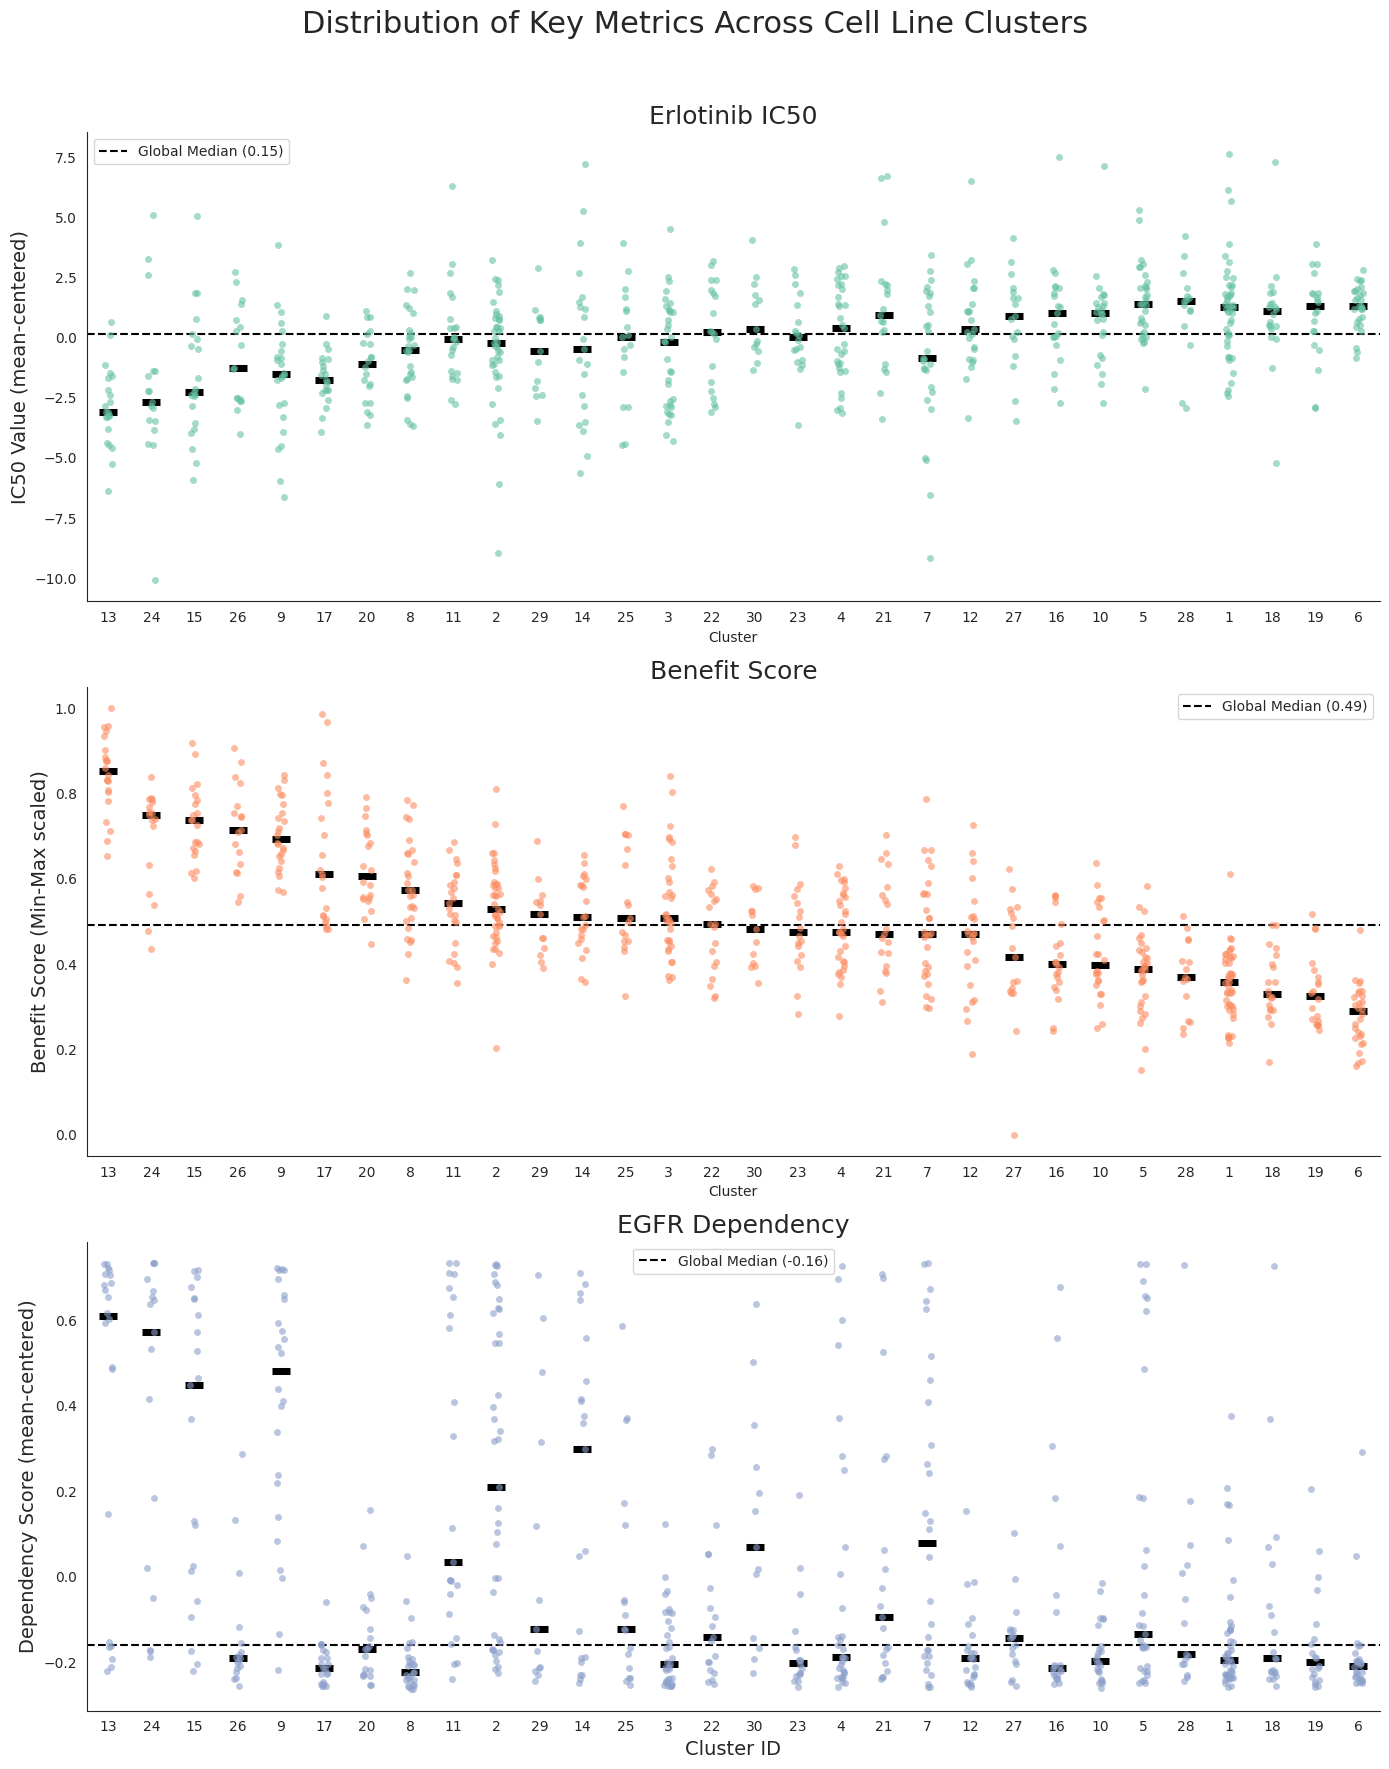

In [32]:
# Assume `plot_df` and `ic50_order` are already defined in your environment
ic50_order = z_values_df.groupby('Cluster')['benefit_score_scaled'].median().sort_values(ascending=False).index
# === Global Medians ===
median_ic50 = z_values_df['scaled_ic50'].median()
median_benefit = z_values_df['benefit_score_scaled'].median()
median_dependency = z_values_df['scaled_dep'].median()

# Set style
sns.set_style("white")

# Use Set2 color palette
palette = sns.color_palette("Set2", 3)  # Get 3 distinct colors
color_ic50 = palette[0]
color_dep = palette[2]
color_bs = palette[1]

# Create vertical subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=False)
fig.suptitle('Distribution of Key Metrics Across Cell Line Clusters', fontsize=22, y=0.98)

# --- Plot 1: IC50 ---
sns.stripplot(data=z_values_df, x='Cluster', y='scaled_ic50', order=ic50_order,
              ax=axes[0], jitter=True, alpha=0.6, color=color_ic50)
sns.pointplot(data=z_values_df, x='Cluster', y='scaled_ic50', order=ic50_order,
              ax=axes[0], estimator=np.median, color="black",
              markers="_", scale=2.5, linestyles="", errorbar=None)
axes[0].axhline(median_ic50, color='black', linestyle='--', linewidth=1.5,
                label=f'Global Median ({median_ic50:.2f})')
axes[0].set_title('Erlotinib IC50', fontsize=18)
axes[0].set_ylabel('IC50 Value (mean-centered)', fontsize=14)
axes[0].legend()
sns.despine(ax=axes[0])

# --- Plot 2: Benefit Score ---
sns.stripplot(data=z_values_df, x='Cluster', y='benefit_score_scaled', order=ic50_order,
              ax=axes[1], jitter=True, alpha=0.6, color=color_bs)
sns.pointplot(data=z_values_df, x='Cluster', y='benefit_score_scaled', order=ic50_order,
              ax=axes[1], estimator=np.median, color="black",
              markers="_", scale=2.5, linestyles="", errorbar=None)
axes[1].axhline(median_benefit, color='black', linestyle='--', linewidth=1.5,
                label=f'Global Median ({median_benefit:.2f})')
axes[1].set_title('Benefit Score', fontsize=18)
axes[1].set_ylabel('Benefit Score (Min-Max scaled)', fontsize=14)
axes[1].legend()
sns.despine(ax=axes[1])

# --- Plot 3: EGFR Dependency ---
sns.stripplot(data=z_values_df, x='Cluster', y='scaled_dep', order=ic50_order,
              ax=axes[2], jitter=True, alpha=0.6, color=color_dep)
sns.pointplot(data=z_values_df, x='Cluster', y='scaled_dep', order=ic50_order,
              ax=axes[2], estimator=np.median, color="black",
              markers="_", scale=2.5, linestyles="", errorbar=None)
axes[2].axhline(median_dependency, color='black', linestyle='--', linewidth=1.5,
                label=f'Global Median ({median_dependency:.2f})')
axes[2].set_title('EGFR Dependency', fontsize=18)
axes[2].set_ylabel('Dependency Score (mean-centered)', fontsize=14)
axes[2].set_xlabel('Cluster ID', fontsize=14)
axes[2].legend()
sns.despine(ax=axes[2])

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

for coll in axes[0].collections:
    coll.set_rasterized(True)
for coll in axes[1].collections:
    coll.set_rasterized(True)
for coll in axes[2].collections:
    coll.set_rasterized(True)

fig.savefig("/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Figs/clusterSpecific_scatterPlots_newHP_optuna.pdf", dpi=600, bbox_inches='tight')

plt.show()


Clusters 26,10,25 are the best clusters

In [33]:
best_cellLines = z_values_df.loc[z_values_df['Cluster'] == target_cluster_id, 'cell_line'].to_list()
len(best_cellLines)

22

In [34]:
z_values_df.head()

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim24,scaled_dep,scaled_ic50,pred_dep,pred_ic50,set,cell_line,benefit_score_raw,benefit_score_scaled,Cluster
22RV1,15.070516,2.110318,12.507632,-12.300128,12.533052,-7.315223,-3.968436,2.595230,-6.310228,12.178791,...,-0.619777,-0.233832,1.411675,0.002936,0.292963,test,22RV1,-0.290027,0.471528,4
2313287,15.126697,3.992169,-2.582105,-0.565921,15.970295,-1.398219,6.329730,18.360206,-0.696256,12.463213,...,-0.064647,0.069716,0.803095,0.071632,-0.638585,train,2313287,0.710217,0.593435,4
253J,-25.841629,5.444899,-13.283011,-8.433864,4.070306,16.237590,9.521778,-15.382223,13.286316,-8.847282,...,11.142777,-0.185868,-2.569515,0.112350,0.460678,train,253J,-0.348327,0.464423,7
253JBV,-20.077915,4.045209,-18.874968,-7.184408,13.056097,9.383398,-2.857666,-5.584618,9.323419,-7.079888,...,5.950287,-0.172234,-1.333165,0.160201,-0.326895,train,253JBV,0.487096,0.566242,7
42MGBA,3.426879,-11.711808,20.527376,-6.841866,-22.475261,-4.091241,13.658918,-6.201748,21.617220,-4.023104,...,-4.732990,-0.211662,1.782755,-0.227809,1.702960,test,42MGBA,-1.930768,0.271559,6


In [35]:
# z_values_df['susceptibility_cat'] = np.where(z_values_df['cell_line'].isin(egfr_susceptible_cell_lines), 'susceptible',
#     np.where(z_values_df['cell_line'].isin(egfr_resistant_cell_lines), 'resistant', 'non-key cluster'))
# z_values_df['susceptibility_cat'].value_counts()

In [36]:
z_values_df['EGFR_exp'] = exp_data.loc[z_values_df.index, 'EGFR']

In [37]:
z_values_df['EGFR_exp'].describe()

count    686.000000
mean       5.936978
std        3.683115
min       -8.253510
25%        3.923119
50%        7.317121
75%        8.395772
max       13.151641
Name: EGFR_exp, dtype: float64

In [38]:
from scipy.stats import mannwhitneyu

In [39]:
# # ---------------------------
# # Parameters
# # ---------------------------
# order = ['non-key cluster', 'susceptible', 'resistant']
# palette = {'non-key cluster' : 'lightblue', 'susceptible': 'green', 'resistant': 'cyan'}
# pairs = [
#     ('non-key cluster', 'susceptible'),
#     ('non-key cluster', 'resistant'),
#     ('resistant', 'susceptible')  # susceptible > resistant
# ]

# # ---------------------------
# # Plot
# # ---------------------------
# plt.figure(figsize=(8, 6))
# ax = plt.gca()

# # Boxplot (robust summary)
# sns.boxplot(
#     data=z_values_df,
#     x='susceptibility_cat',
#     y='EGFR_exp',
#     order=order,
#     width=0.2, palette=palette,
#     showcaps=True,
#     showfliers=False,
#     # boxprops=dict(facecolor='none'),
#     medianprops=dict(color='black'),
#     ax=ax
# )

# # Jittered points (distribution)
# sns.stripplot(
#     data=z_values_df,
#     x='susceptibility_cat',
#     y='EGFR_exp',
#     order=order,
#     color='black',
#     alpha=0.35,
#     jitter=0.25,
#     size=3,
#     ax=ax
# )

# # ---------------------------
# # Statistics + annotations
# # ---------------------------
# y_max = z_values_df['EGFR_exp'].max()
# y_min = z_values_df['EGFR_exp'].min()
# y_step = (y_max - y_min) * 0.10

# print("\nPairwise Mann–Whitney U results (alternative = test > reference):\n")

# for i, (ref, test) in enumerate(pairs):

#     ref_vals = z_values_df.loc[
#         z_values_df['susceptibility_cat'] == ref, 'EGFR_exp'
#     ].dropna()

#     test_vals = z_values_df.loc[
#         z_values_df['susceptibility_cat'] == test, 'EGFR_exp'
#     ].dropna()

#     # One-sided Mann–Whitney
#     stat, pval = mannwhitneyu(
#         test_vals,
#         ref_vals,
#         alternative='greater'
#     )

#     print(f"{test} > {ref}")
#     print(f"  p-value = {pval:.3e}")

#     # Annotation positions
#     x1 = order.index(ref)
#     x2 = order.index(test)
#     y = y_max + (i + 1) * y_step

#     # Bracket
#     ax.plot(
#         [x1, x1, x2, x2],
#         [y, y + y_step * 0.25, y + y_step * 0.25, y],
#         lw=1.2,
#         color='black'
#     )

#     # Text
#     ax.text(
#         (x1 + x2) / 2,
#         y + y_step * 0.28,
#         f"p = {pval:.2e}",
#         ha='center',
#         va='bottom',
#         fontsize=9
#     )

# # ---------------------------
# # Final formatting
# # ---------------------------
# ax.set_xlabel('')
# ax.set_ylabel('EGFR expression')
# sns.despine()
# plt.tight_layout()
# plt.savefig('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Figs/egfrExpression_keyCluster_optuna.pdf', dpi=600, bbox_inches='tight')
# plt.show()


#### Model performances

In [40]:
def plot_pred_vs_true(x, y, ax, title):
    # Stats
    pearson_r, _ = pearsonr(x, y)
    spearman_rho, _ = spearmanr(x, y)
    ci = concordance_index(x, y)

    # Regression fit
    a, b = np.polyfit(x, y, 1)
    y_fit = a * x + b
    r2 = r2_score(y, y_fit)

    # Plot scatter
    sns.scatterplot(x=x, y=y, s=40, ax=ax)

    # Regression line
    xx = np.linspace(x.min(), x.max(), 200)
    yy = a * xx + b
    ax.plot(xx, yy, linewidth=2, color='red')

    # Text box
    textstr = (
        f"Pearson r: {pearson_r:.3f}\n"
        f"Spearman ρ: {spearman_rho:.3f}\n"
        f"R² (fit): {r2:.3f}\n"
        f"CI: {ci:.3f}"
    )
    ax.text(
        0.05, 0.95, textstr,
        transform=ax.transAxes,
        fontsize=11, va='top',
        bbox=dict(boxstyle="round", fc="white", alpha=0.6)
    )

    ax.set_title(title)
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")

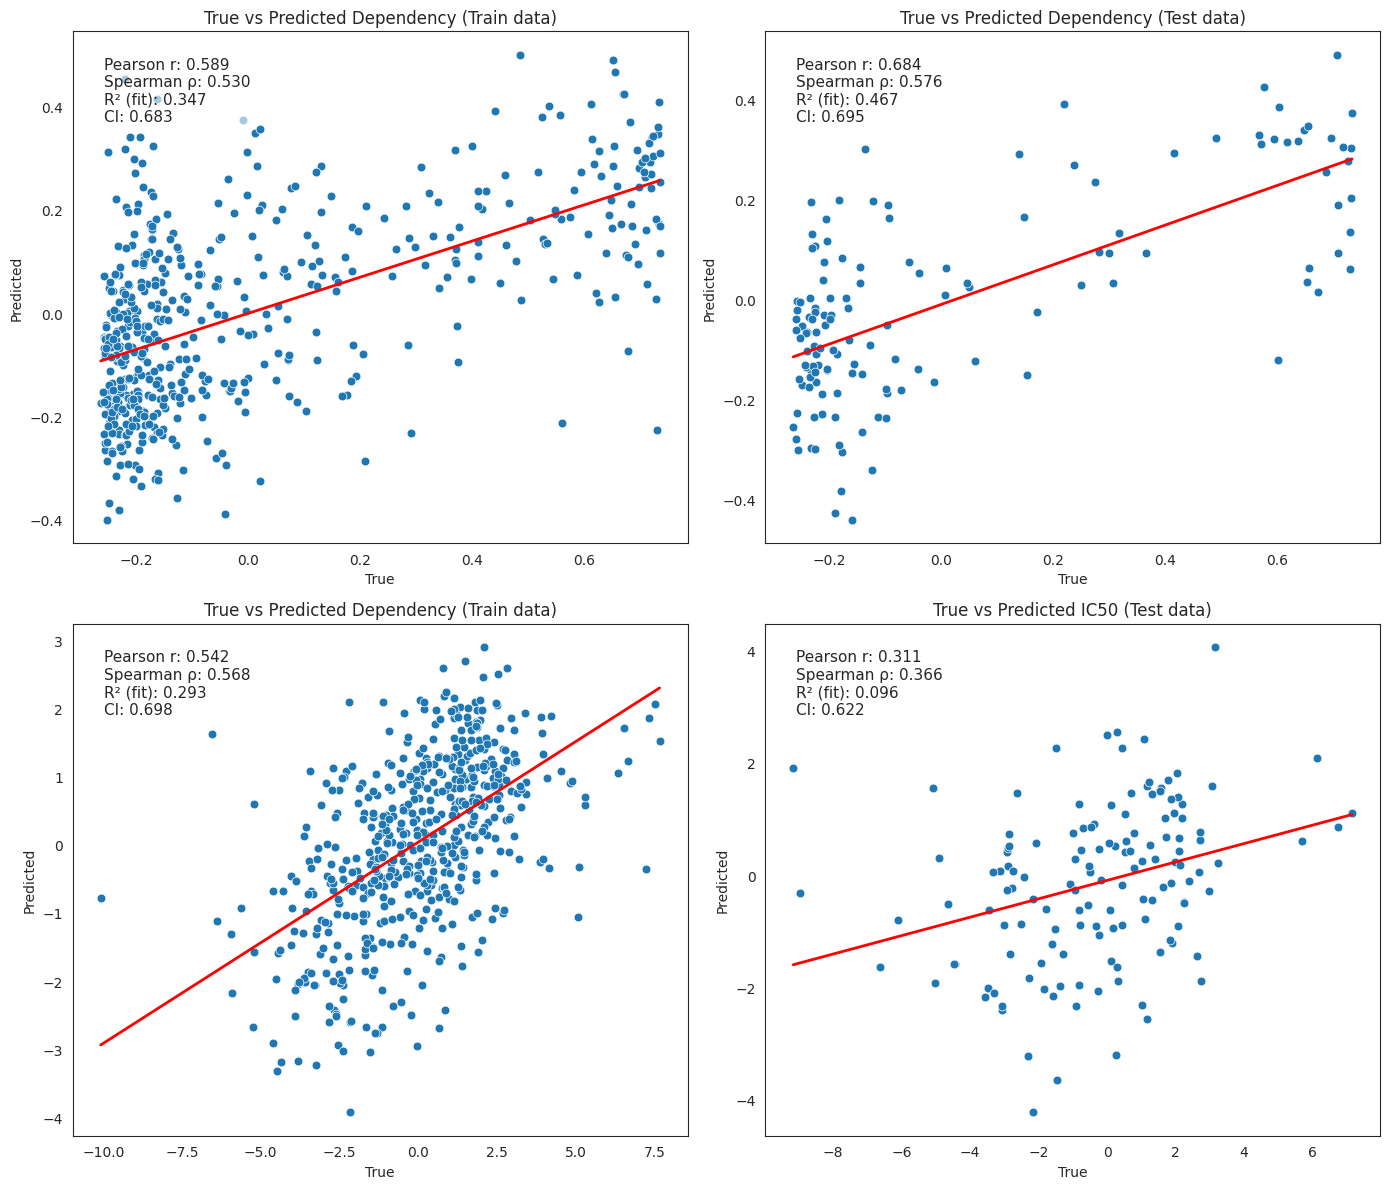

In [41]:
train_exp = (G_train - forge_model.mean_exp.values) / forge_model.std_exp.values
test_exp  = (G_test  - forge_model.mean_exp.values) / forge_model.std_exp.values
# ---------------------------
# Create two plots
# ---------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Dependency
x_dep_train = D_train.ravel()
y_dep_train = (train_exp @ forge_model.W @ forge_model.hD).ravel()

plot_pred_vs_true(x_dep_train, y_dep_train, axes[0,0],
                  "True vs Predicted Dependency (Train data)")

x_dep_test = D_test.ravel()
y_dep_test = (test_exp @ forge_model.W @ forge_model.hD).ravel()

plot_pred_vs_true(x_dep_test, y_dep_test, axes[0,1],
                  "True vs Predicted Dependency (Test data)")

# IC50
x_ic50_train = I_train.ravel()
y_ic50_train = (train_exp @ forge_model.W @ forge_model.hI).ravel()

plot_pred_vs_true(x_ic50_train, y_ic50_train, axes[1,0],
                  "True vs Predicted Dependency (Train data)")

x_ic50_test = I_test.ravel()
y_ic50_test = (test_exp @ forge_model.W @ forge_model.hI).ravel()

plot_pred_vs_true(x_ic50_test, y_ic50_test, axes[1,1],
                  "True vs Predicted IC50 (Test data)")

plt.tight_layout()
plt.savefig("/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Figs/EGFR_Erlotinib_newHP_performances_optuna.pdf", dpi=600, bbox_inches='tight')
plt.show()


In [42]:
z_values_df.to_csv('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/egfr_erlotinib_fullRes_optuna.csv', index=True)